#**Data Generation**

##**1. Libraries and Disk**

In [ ]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
from openslide.deepzoom import DeepZoomGenerator
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls '/content/drive/My Drive/ADL Project'

Images	Image_sets_20  Image_sets_50  model


In [ ]:
!ls '/content/drive/My Drive/ADL Project/Images'

tumor_001_mask.tif  tumor_019.xml	tumor_059.xml	    tumor_091.tif
tumor_001.tif	    tumor_023_mask.tif	tumor_064_mask.tif  tumor_091.xml
tumor_001.xml	    tumor_023.tif	tumor_064.tif	    tumor_094_mask.tif
tumor_002_mask.tif  tumor_023.xml	tumor_064.xml	    tumor_094.tif
tumor_002.tif	    tumor_031_mask.tif	tumor_075_mask.tif  tumor_094.xml
tumor_002.xml	    tumor_031.tif	tumor_075.tif	    tumor_096_mask.tif
tumor_005_mask.tif  tumor_031.xml	tumor_075.xml	    tumor_096.tif
tumor_005.tif	    tumor_035_mask.tif	tumor_078_mask.tif  tumor_096.xml
tumor_005.xml	    tumor_035.tif	tumor_078.tif	    tumor_101_mask.tif
tumor_012_mask.tif  tumor_035.xml	tumor_078.xml	    tumor_101.tif
tumor_012.tif	    tumor_038.tif	tumor_081_mask.tif  tumor_101.xml
tumor_012.xml	    tumor_038.xml	tumor_081.tif	    tumor_110_mask.tif
tumor_016_mask.tif  tumor_057_mask.tif	tumor_081.xml	    tumor_110.tif
tumor_016.tif	    tumor_057.tif	tumor_084_mask.tif  tumor_110.xml
tumor_016.xml	    tumor_057.xml	tumor_084.ti

##**2. Starter Functions**

In [ ]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [ ]:
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

In [ ]:
def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

In [ ]:
def read_tile(tile, as_float=False):
    im = tile
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    return im

In [ ]:
def get_maching_level(tiles, slide, lv):
  nlv = 0
  for i, dim in enumerate(tiles.level_dimensions):
    if slide.level_dimensions[lv] == dim:
      nlv = i
  return nlv

In [ ]:
def resize_tile(tile_sz, region_unequal, region_mask_unequal):
  region_r = region_unequal.resize((tile_sz, tile_sz))
  region_mask_r = region_mask_unequal.resize((tile_sz, tile_sz))
  return  region_r, region_mask_r

##**3. Level parameter, tile size and tissue threshold**

In [ ]:
#Slides_all=['001', '002', '005', '012', '016', '019', '023', '031', '038', '035', '057', '059', '064', '075', '078', '081', '084', '091', '094', '096', '101', '110']
#Slides_train = ['001', '002', '005', '012', '016', '019', '023', '031','035', '057', '059', '064', '075', '078', '081', '084', '091']
#Slides_test = ['038', '094', '096', '101', '110']

In [ ]:
np.random.seed(0)
x = ['001', '002', '005', '012', '016', '019', '023', '031', '035', '057', '059', '064', '075', '078', '081', '084', '091', '094', '096', '101', '110']
np.random.shuffle(x)

Slides_train = x[:17] #x[:17] 
Slides_test = x[17:]  #x[17:]
#Slides_test.append('038')

In [ ]:
##Choose parametres for level, tile size and center
lv = 5
tile_sz = 256
tissue_threshold = 20
mask_threshold = 20

In [ ]:
path_dir_images = os.getcwd() + '/drive/My Drive/ADL Project/Images'

## **4. Tile and label Generator**

In [ ]:
def tile_label_generator(slide_path, tumor_mask_path, tile_sz, lv, tissue_threshold, mask_threshold):

  slide = open_slide(slide_path)
  tumor_mask = open_slide(tumor_mask_path)

  tiles = DeepZoomGenerator(slide, tile_size=tile_sz, overlap=0, limit_bounds=True)
  tiles_mask = DeepZoomGenerator(tumor_mask, tile_size=tile_sz, overlap=0, limit_bounds=True)

  nlv = get_maching_level(tiles, slide, lv)

  tile_im = []
  mask_im = []
  label = []

  for i in range(tiles.level_tiles[nlv][1]):
    for j in range(tiles.level_tiles[nlv][0]):

      region = tiles.get_tile(nlv, (j,i))
      region_mask = tiles_mask.get_tile(nlv, (j,i))

      if region != (tile_sz, tile_sz) or region_mask != (tile_sz, tile_sz):
        region, region_mask  = resize_tile(tile_sz, region, region_mask)
      else:
        region = region
        region_mask = region_mask

      tile = read_tile(region)
      tile_mask = read_tile(region_mask)[:,:,0]

      tissue_pixels = find_tissue_pixels(tile)
      percent_tissue = len(tissue_pixels) / float(tile.shape[0] * tile.shape[1]) * 100

      mask_pixels = find_tissue_pixels(tile_mask)
      percent_mask = 100 - len(mask_pixels) / float(tile_mask.shape[0] * tile_mask.shape[1]) * 100

      ind_tumor = np.sum(tile_mask[int(tile_sz/4): int(tile_sz/4+tile_sz/2), int(tile_sz/4): int(tile_sz/4+tile_sz/2)])

      if percent_tissue >= tissue_threshold and ind_tumor > 0.0:
        tile_im.append(tile)
        mask_im.append(tile_mask)
        label.append(1)

      if percent_tissue >= tissue_threshold and ind_tumor <= 0.0:
        tile_im.append(tile)
        mask_im.append(tile_mask)
        label.append(0)

      else:
        continue
  
  return tile_im, mask_im, label

##**5. Generate Images and labels for the train and validation set**

In [ ]:
%%time
IMG = []
MSK = []
LBL = []

for i in range(len(Slides_train)):
  slide_path = path_dir_images +'/' +'tumor_' + Slides_train[i] +'.tif'
  tumor_mask_path = path_dir_images +'/' +'tumor_' + Slides_train[i] +'_mask.tif'
  tile_im, mask_im, label = tile_label_generator(slide_path, tumor_mask_path, tile_sz, lv, tissue_threshold, mask_threshold)
  IMG.extend(tile_im)
  MSK.extend(mask_im)
  LBL.extend(label)

CPU times: user 1min 47s, sys: 963 ms, total: 1min 48s
Wall time: 1min 51s


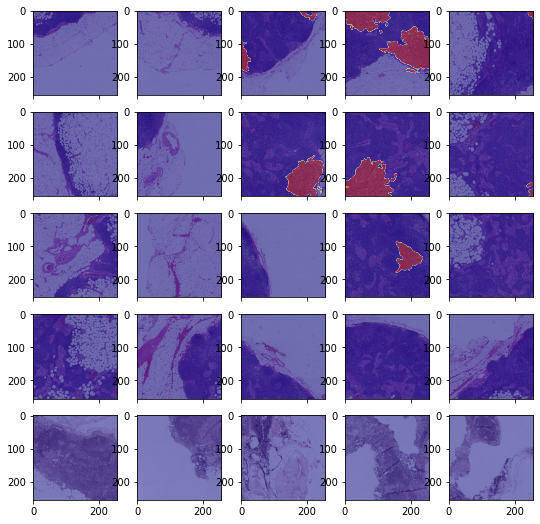

In [ ]:
fig, axes = plt.subplots(5,5, figsize=(9, 9), sharex = True)

for i, ax in enumerate(axes.ravel()):
    if i > 10 * 10:
        ax.set_visible(False)
        continue
    ax.imshow(IMG[len(LBL)-i-100])
    ax.imshow(MSK[len(LBL)-i-100], cmap='jet', alpha=0.5)

In [ ]:
print("Size for the sample(trainig and validation) set:", len(IMG))
print("Number of labels:", len(LBL))
print("Number of tiles containing tumors:", sum(LBL))
print("Percentage of tumors in the sample:", sum(LBL)/len(LBL))

Size for the sample(trainig and validation) set: 544
Number of labels: 544
Number of tiles containing tumors: 107
Percentage of tumors in the sample: 0.19669117647058823


##**6. Generate Images and labels for the test set**

In [ ]:
%%time
IMG_test = []
MSK_test = []
LBL_test = []

for i in range(len(Slides_test)):
  slide_path = path_dir_images +'/' +'tumor_' + Slides_test[i] +'.tif'
  tumor_mask_path = path_dir_images +'/' +'tumor_' + Slides_test[i] +'_mask.tif'
  tile_im, mask_im, label = tile_label_generator(slide_path, tumor_mask_path, tile_sz, lv, tissue_threshold, mask_threshold)
  IMG_test.extend(tile_im)
  MSK_test.extend(mask_im)
  LBL_test.extend(label)

CPU times: user 21.9 s, sys: 266 ms, total: 22.2 s
Wall time: 22.8 s


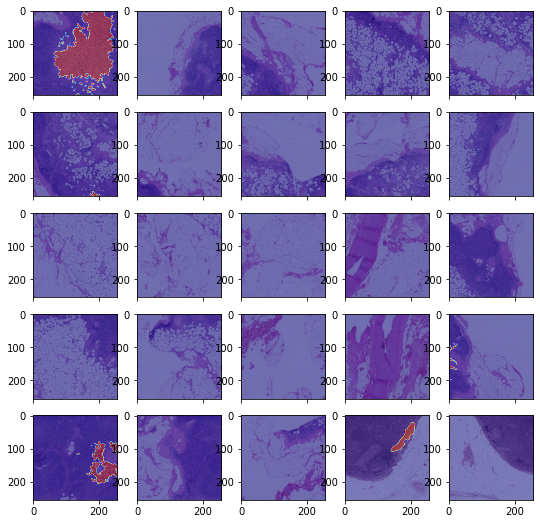

In [ ]:
fig, axes = plt.subplots(5,5, figsize=(9, 9), sharex = True)

for i, ax in enumerate(axes.ravel()):
    if i > 10 * 10:
        ax.set_visible(False)
        continue
    ax.imshow(IMG_test[len(LBL_test)-i-40])
    ax.imshow(MSK_test[len(LBL_test)-i-40], cmap='jet', alpha=0.5)

In [ ]:
print("Size for the test set:", len(IMG_test))
print("Number of labels:", len(LBL_test))
print("Number of tiles containing tumors:", sum(LBL_test))
print("Percentage of tumors in the sample:", sum(LBL_test)/len(LBL_test))

Size for the test set: 133
Number of labels: 133
Number of tiles containing tumors: 10
Percentage of tumors in the sample: 0.07518796992481203


##**7. Extract a validation set from the training set**

In [ ]:
IMG_train, IMG_val, MSK_train, MSK_val, LBL_train, LBL_val = train_test_split(IMG, MSK, LBL, test_size=0.2, random_state=42, stratify=LBL, shuffle=True)

In [ ]:
del IMG, MSK, LBL

In [ ]:
print("Size for the training set:", len(IMG_train))
print("Number of labels:", len(LBL_train))
print("Number of tiles containing tumors:", sum(LBL_train))
print("Percentage of tumors in the sample:", sum(LBL_train)/len(LBL_train))

Size for the training set: 435
Number of labels: 435
Number of tiles containing tumors: 86
Percentage of tumors in the sample: 0.19770114942528735


In [ ]:
print("Size for the validation set:", len(IMG_val))
print("Number of labels:", len(LBL_val))
print("Number of tiles containing tumors:", sum(LBL_val))
print("Percentage of tumors in the sample:", sum(LBL_val)/len(LBL_val))

Size for the validation set: 109
Number of labels: 109
Number of tiles containing tumors: 21
Percentage of tumors in the sample: 0.1926605504587156


##**8. Save as an array the training, validation and test set**

In [ ]:
Image_label_Level5 = {'IMG_train' : IMG_train, 'MSK_train' : MSK_train, 'LBL_train' : LBL_train,
                'IMG_val' : IMG_val, 'MSK_val' : MSK_val, 'LBL_val' : LBL_val,
                'IMG_test' : IMG_test, 'MSK_test' : MSK_test, 'LBL_test' : LBL_test}

In [ ]:
path_save = os.getcwd() + '/drive/My Drive/ADL Project/Image_sets_20'
path_save

'/content/drive/My Drive/ADL Project/Image_sets_20'

In [ ]:
if not os.path.exists(path_save):
    os.makedirs(path_save)

In [ ]:
np.save(path_save + '/Image_label_Level_5', Image_label_Level5)